In [1]:
!pip install --upgrade gdown
!pip install catboost
!pip3 install optuna

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.9 MB/s eta 0:00:00


In [161]:
import numpy as np
import pandas as pd
import gdown
from catboost import CatBoostClassifier
from sklearn.metrics  import roc_auc_score
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

import optuna
from optuna.samplers import TPESampler
import catboost
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

In [3]:
!gdown 17ReWp93rAKo2UMT0Xe9Vri2DhnwCVYHt
!gdown 1TJmPMOXubS3uPR-z_BWWK397KjaPtQXQ

Downloading...
From: https://drive.google.com/uc?id=17ReWp93rAKo2UMT0Xe9Vri2DhnwCVYHt
To: /content/train_df (2).csv
100% 7.22M/7.22M [00:00<00:00, 89.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TJmPMOXubS3uPR-z_BWWK397KjaPtQXQ
To: /content/test_df (3).csv
100% 730k/730k [00:00<00:00, 105MB/s]


In [4]:
train = pd.read_csv('/content/train_df (2).csv')
test = pd.read_csv('/content/test_df (3).csv')
print('Конец теста')
display(test.tail())
print('Конец трейна')
display(train.tail())

Конец теста


,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
1524,493078,9,0,0,0,9,4,35,0,0,...,0.341683,0.067348,0.023012,0,0,0,0.46108,0.0,0.0,0
1525,493078,9,0,0,0,9,4,35,0,0,...,0.270293,0.049000,0.013244,0,0,0,0.03674,0.0,0.0,0
1526,493078,9,0,0,0,9,4,35,0,0,...,0.372268,0.069882,0.026015,0,0,0,0.14540,0.0,0.0,1
1527,493078,9,0,0,0,9,4,35,0,0,...,0.355755,0.077469,0.027560,0,0,0,0.21288,0.0,0.0,1
1528,493078,9,0,0,0,9,4,35,0,0,...,0.260349,0.068786,0.017908,0,0,0,0.20751,0.0,0.0,0


Конец трейна


,search_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,target
15076,494693,9,0,0,0,9,4,38,6,6,...,0.309672,0.921060,0.285226,0,0,0,0.98807,0.0,0.0,0
15077,494693,9,0,0,0,9,4,38,6,6,...,0.303805,0.995086,0.302312,0,0,0,0.87146,0.0,0.0,0
15078,494693,9,0,0,0,9,4,38,6,6,...,0.346538,0.993070,0.344137,0,0,0,0.49999,0.0,0.0,0
15079,494693,9,0,0,0,9,4,38,6,6,...,0.243154,0.994833,0.241898,0,0,0,0.67614,0.0,0.0,0
15080,494693,9,0,0,0,9,4,38,6,6,...,0.294564,0.987208,0.290796,0,0,0,0.53674,0.0,0.0,1


Анализ данных

**Предположение первое**
Надо сделать рекомендации для валидных товаров  для каждого search_id, и соответственно посчитать метрику ndcg для каждого search_id



In [194]:
len(set(train['search_id']).intersection(test['search_id']))

0

Пересечений нет между тестом и трейном нет, поэтому будем считать метрику на всем множестве

In [199]:
#Посмотрим на корреляции
corr = train.corr()
sorted(corr['target'], reverse = True)[:10]

[nan,
 0.08584117796250261,
 0.05024903604357184,
 0.04712507611826474,
 0.04655988658642063,
 0.02547854627437983,
 0.02355278959827514,
 0.02288473543073835,
 0.018337447875133344,
 0.01688726034134971]

Нормальных корреляций нет в принципе, сильно высоких результатов ждать не стоит

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train = train.drop('target', axis =1)
y_train = train['target']
X_test = test.drop('target', axis =1)
y_test = test['target']

Посмотрим на дефолтные результаты catboost

In [201]:
model = CatBoostClassifier().fit(X_train, y_train, verbose = False)
a = np.asarray([y_test])
b = np.asarray([model.predict_proba(X_test)[:, 1].tolist()])
ndcg_score(a,b) # не 0 уже неплохо

0.49042530195652606

Используем Optuna для того чтобы улучшить результат

In [202]:
def objective(trial, X_train = X_train, y_train = y_train):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 500),

        depth=trial.suggest_int("depth", 1, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    skf = StratifiedKFold(n_splits=7, shuffle= True,  random_state=500) #оценивать гиперпараметры будем по валидационной выборке
    result = [0]*7
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):

      train_cv = X_train.iloc[train_index]
      y_train_cv = y_train[train_index]
      val_cv = X_train.iloc[test_index]
      y_val_cv = y_train[test_index]

      model.fit(train_cv, y_train_cv)

      y_val_true = np.asarray([y_val_cv])
      y_val_prediction = np.asarray([model.predict_proba(val_cv)[:, 1].tolist()])

      result[i] = ndcg_score(y_val_true ,y_val_prediction)
    return np.mean(result[i])
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.5790460786622601
  Params: 
    iterations: 144
    depth: 7
    l2_leaf_reg: 0.499066358443914
    bootstrap_type: Bayesian
    random_strength: 1.099259825686884
    bagging_temperature: 2.7157807207567646
    od_type: Iter
    od_wait: 20


In [205]:
best_params = {
    'iterations': 144,
    'depth': 7,
    'l2_leaf_reg': 0.499066358443914,
    'bootstrap_type': 'Bayesian',
    'random_strength': 1.099259825686884,
    'bagging_temperature': 2.7157807207567646,
    'od_type': 'Iter',
    'od_wait': 20
}
model = catboost.CatBoostClassifier(**best_params, verbose=False)
model.fit(X_train, y_train)
a = np.asarray([y_test])
b = np.asarray([model.predict_proba(X_test)[:, 1].tolist()])

ndcg_score(a,b)

0.5481227944553249

Затратив миниум услий получили весомое улучшение, теперь посмотрим на значимость фичей

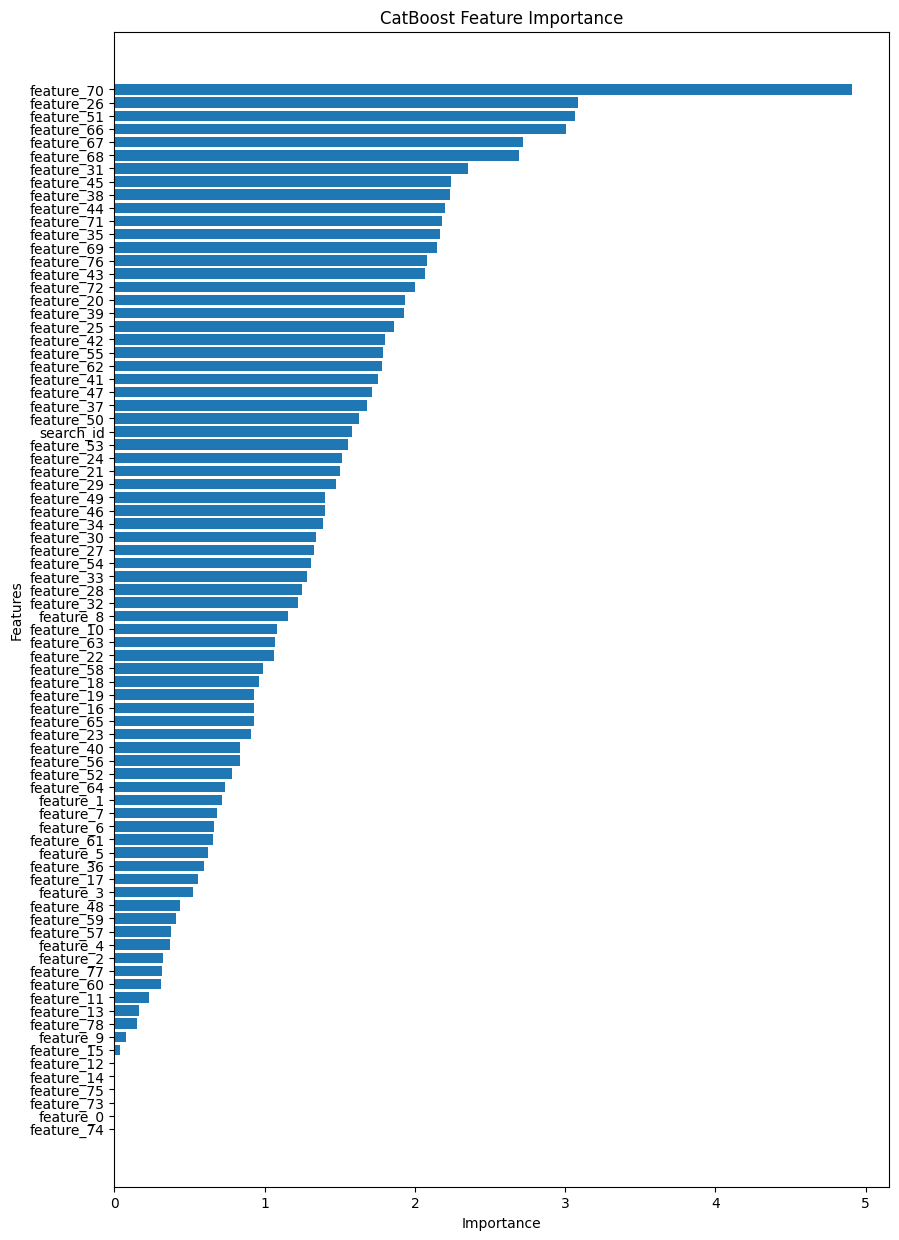

In [109]:
importances = model1.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 15))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Учитывая значимый разлет по важности признаков, вероятно, некоторые из них абсолютно бесполезны для этой задачи

# Проведем отбор признаков

**Лирическое отступление:**

Полноценный отбор признаков невозможен, так как фичи абсолютно не интерпретируемы

Cделаем отбор при помощи Lasso

In [206]:
select = SelectFromModel(LogisticRegression(penalty = 'l1',solver = 'liblinear',random_state=777), threshold= 10**(-5))
select.fit(X_train, y_train)
X_train_selected = select.transform(X_train)
print(X_train.shape)
print(X_train_selected.shape)

(15081, 80)
(15081, 45)


In [212]:
X_test_selected = select.transform(X_test)
model.fit(X_train_selected, y_train)
a = np.asarray([y_test])
b = np.asarray([model.predict_proba(X_test_selected)[:, 1].tolist()])
ndcg_score(a,b)

0.5491466436883202

Наблюдаем знанчимое улучшение дефолтного результата

Теперь попробуем сделать сделать тюнинг

In [123]:
X_train_selected= pd.DataFrame(X_train_selected).copy()
def objective(trial, X_train = X_train_selected, y_train = y_train):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 500),

        depth=trial.suggest_int("depth", 1, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    skf = StratifiedKFold(n_splits=7, shuffle= True,  random_state=500)
    result = [0]*7
    for i, (train_index, test_index) in enumerate(skf.split(X_train_selected, y_train)):

      train_cv = X_train_selected.iloc[train_index]
      y_train_cv = y_train[train_index]
      val_cv = X_train_selected.iloc[test_index]
      y_val_cv = y_train[test_index]

      model.fit(train_cv, y_train_cv)

      y_val_true = np.asarray([y_val_cv])
      y_val_prediction = np.asarray([model.predict_proba(val_cv)[:, 1].tolist()])

      result[i] = ndcg_score(y_val_true ,y_val_prediction)
    return np.mean(result[i])
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar = True)

  0%|          | 0/100 [00:00<?, ?it/s]

Training has stopped (degenerate solution on iteration 99, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 113, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 242, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 82, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 46, probably too small l2-regularization, try to increase it)
Training has stopped (degenerate solution on iteration 431, probably too small l2-regularization, try to increase it)


In [124]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.5771148721534115
  Params: 
    iterations: 183
    depth: 4
    l2_leaf_reg: 0.00020750916574915811
    bootstrap_type: Bayesian
    random_strength: 0.38541062272198556
    bagging_temperature: 9.079554677072222
    od_type: IncToDec
    od_wait: 34


In [235]:
best_params = {
    'iterations': 183,
    'depth': 4,
    'l2_leaf_reg': 0.00020750916574915811,
    'bootstrap_type': 'Bayesian',
    'random_strength': 0.38541062272198556,
    'bagging_temperature': 9.079554677072222,
    'od_type': 'IncToDec',
    'od_wait': 34
}
model_best = catboost.CatBoostClassifier(**best_params, verbose=False)
model_best.fit(X_train_selected, y_train)
a = np.asarray([y_test])
b = np.asarray([model_best.predict_proba(X_test_selected)[:, 1].tolist()])

ndcg_score(a,b)

0.5554448932839412

Улучшение сработало, однако значимого роста качества достичь не удалось

Теперь попробуем сократить изначальное признаковое пространство, при помощи PCA. Число главных компонент примим за гиперапараметр и будет отбирать по валидационной выборке

In [177]:
for k in range(10, 80, 5):
  pipeline = Pipeline([
    ('scaler', StandardScaler()), #не забудем провести стандартизацию
    ('pca', PCA(n_components=k, random_state = 42)), #зафиксируем seed

  ])

  X_train_processed = pipeline.fit_transform(X_train.drop('search_id', axis=1).copy())


  result = [0]*7
  skf = StratifiedKFold(n_splits=7, shuffle= True,  random_state=500)
  for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)): #сделаем валидацию
      X_train_processed = pd.DataFrame(X_train_processed)
      train_cv = X_train_processed.iloc[train_index]
      y_train_cv = y_train[train_index]
      val_cv = X_train_processed.iloc[test_index]
      y_val_cv = y_train[test_index]
      model_pca = catboost.CatBoostClassifier( verbose=False, random_state = 42)
      model_pca.fit(train_cv, y_train_cv)

      y_val_true = np.asarray([y_val_cv])
      y_val_prediction = np.asarray([model_pca.predict_proba(val_cv)[:, 1].tolist()])

      result[i] = ndcg_score(y_val_true ,y_val_prediction)

  print('Число компонент', k, 'Итоговый результат', np.mean(result) )


Число компонент 10 Итоговый результат 0.45357804421289344
Число компонент 15 Итоговый результат 0.45377755144696297
Число компонент 20 Итоговый результат 0.4636243903648737
Число компонент 25 Итоговый результат 0.46388240491229793
Число компонент 30 Итоговый результат 0.48014614744801526
Число компонент 35 Итоговый результат 0.4733898108269202
Число компонент 40 Итоговый результат 0.4754503673689608
Число компонент 45 Итоговый результат 0.48312565362456816
Число компонент 50 Итоговый результат 0.4767283032374673
Число компонент 55 Итоговый результат 0.4716182719113667
Число компонент 60 Итоговый результат 0.4662240389358176
Число компонент 65 Итоговый результат 0.46197525374352727
Число компонент 70 Итоговый результат 0.46462010374682217
Число компонент 75 Итоговый результат 0.47061069467872174


Лучший результат прии 45 компонентах

In [217]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=45, random_state = 42)),

  ])

X_train_processed = pipeline.fit_transform(X_train.drop('search_id', axis=1).copy())
X_test_processed = pipeline.fit_transform(X_test.drop('search_id', axis=1).copy())

model_pca = catboost.CatBoostClassifier( verbose=False, random_state = 42)
model_pca.fit(X_train_processed, y_train)
a = np.asarray([y_test])
b = np.asarray([model_pca.predict_proba(X_test_processed)[:, 1].tolist()])
ndcg_score(a,b) #по непонятной причине результат на тесте сильно хуже валидационной выборки

0.3966995587064165

Тем не менее сделаем тюнинг, возможно нам повезет

In [190]:
def objective(trial, X_train_processed = X_train_processed):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 500),

        depth=trial.suggest_int("depth", 1, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    skf = StratifiedKFold(n_splits=7, shuffle= True,  random_state=500)
    X_train_processed = pd.DataFrame(X_train_processed)
    result = [0]*7
    for i, (train_index, test_index) in enumerate(skf.split(X_train_processed, y_train)):
      train_cv = X_train_processed.iloc[train_index]
      y_train_cv = y_train[train_index]
      val_cv = X_train_processed.iloc[test_index]
      y_val_cv = y_train[test_index]

      model.fit(train_cv, y_train_cv)

      y_val_true = np.asarray([y_val_cv])
      y_val_prediction = np.asarray([model.predict_proba(val_cv)[:, 1].tolist()])

      result[i] = ndcg_score(y_val_true ,y_val_prediction)
    return np.mean(result[i])
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, show_progress_bar = True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [191]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.5517844193603945
  Params: 
    iterations: 306
    depth: 2
    l2_leaf_reg: 8.081950610781513e-08
    bootstrap_type: Bayesian
    random_strength: 3.6695344055970045
    bagging_temperature: 2.0222754847733024
    od_type: Iter
    od_wait: 15


In [219]:
best_params = {
    'iterations': 306,
    'depth': 2,
    'l2_leaf_reg': 8.081950610781513e-08,
    'bootstrap_type': 'Bayesian',
    'random_strength': 3.6695344055970045,
    'bagging_temperature': 2.0222754847733024,
    'od_type': 'Iter',
    'od_wait': 15
}
model = catboost.CatBoostClassifier(**best_params, verbose=False)
model.fit(X_train_processed, y_train)
a = np.asarray([y_test])
b = np.asarray([model.predict_proba(X_test_processed)[:, 1].tolist()])
ndcg_score(a,b)

0.4376000060071163

чуда не произошло

# Вывод

Лучшее качество мо метрике NDCG- **0.555**

На модели Catboost, после тюнинга с отбором и с предварительным отбором признаков Lasso

**Кратко об неудачных экспериментах**


Попытки сделать ансамбли с RandomForest и другими бустингами не дали ощутимого прироста качаства, а также замена PCA на TSNE, не дала значимого прироста к качеству